# **FINAL PROJECT**

20120522 - Nguyễn Đình Lộc

# **Mô tả bài toán**

Bài toán cài đặt song song hoá lớp convolution của một mạng nơ ron, cụ thể là hai lớp c1 và c3 của một mô hình Lenet-5. Sử dụng framework là mini-DNN và dataset là MNIST Fashion.

Input: Tập dữ liệu MNIST

Output: Thời gian thực thi và độ chính xác, trên host và trên device

Ví dụ sử dụng: Tận dụng GPU để tăng tốc độ giải quyết bài toán của các mạng nơ ron. Việc tăng tốc quá trình huấn luyện hoặc kiểm tra là cần thiết.

# **DEMO**

Đây là file notebook chứa demo cách thực thi code, của nhóm

**Kết nối Google drive**

Mã nguồn nên được tải lên goodle drive và liên kết colab để chạy code

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Chỉnh ổ đĩa chỉ tới thư mục source code**

In [13]:
Base_dir = '/content/drive/MyDrive/LTSS/20120512_20120522_20120538'
%cd "$Base_dir"
!ls

/content/drive/MyDrive/LTSS/20120512_20120522_20120538
build  demo	demo_CPU.cc  demo_GPU	  demo_GPU.o  Eigen	src
data   demo.cc	demo_CPU.o   demo_GPU.cc  demo.o      Makefile


 **Tải Nsight-system**

In [14]:
# Here is the command to install Nsight system on Colab. You just need to run the cell.
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
!apt update
!apt install ./nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
!apt --fix-broken install

--2024-10-19 01:31:05--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317705436 (303M) [application/x-deb]
Saving to: ‘nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb’

nsight-systems-2023 100%[===================>] 302.99M  68.5MB/s    in 4.5s    

2024-10-19 01:31:10 (67.3 MB/s) - ‘nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb’ saved [317705436/317705436]

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://

**Setup nền cho chương trình**

Clean: Dọn dẹp các file không liên quan, file cũ

Run: Biên dịch các đối tượng chính của Lenet-5 (network, mnist, hàm loss, hàm kích hoạt, hàm tối ưu, *các layer trừ layer conv_gpu)

In [15]:
!make clean
!make run

rm -f demo
rm -f demo_CPU
rm -f demo_GPU
rm -f *.o src/*.o src/layer/*.o src/loss/*.o src/optimizer/*.o src/layer/custom/*.o
make network.o
make[1]: Entering directory '/content/drive/MyDrive/LTSS/20120512_20120522_20120538'
nvcc -arch=sm_75 --compile src/network.cc -o src/network.o -I./ -L/usr/local/cuda/lib64 -lcudart
make[1]: Leaving directory '/content/drive/MyDrive/LTSS/20120512_20120522_20120538'
make mnist.o
make[1]: Entering directory '/content/drive/MyDrive/LTSS/20120512_20120522_20120538'
nvcc -arch=sm_75 --compile src/mnist.cc -o src/mnist.o  -I./ -L/usr/local/cuda/lib64 -lcudart
make[1]: Leaving directory '/content/drive/MyDrive/LTSS/20120512_20120522_20120538'
make layer
make[1]: Entering directory '/content/drive/MyDrive/LTSS/20120512_20120522_20120538'
nvcc -arch=sm_75 --compile src/layer/ave_pooling.cc -o src/layer/ave_pooling.o -I./ -L/usr/local/cuda/lib64 -lcudart
nvcc -arch=sm_75 --compile src/layer/conv.cc -o src/layer/conv.o -I./ -L/usr/local/cuda/lib64 -lcudart
nv

## **VERSION 0**
    - Chạy trên CPU

In [16]:
!make version1
!make demo_CPU
!./demo_CPU

rm -f src/layer/custom/*.o demo demo_CPU demo_GPU
nvcc -arch=sm_75 --compile src/layer/custom/gpu_utils.cu -o src/layer/custom/gpu_utils.o -I./ -L/usr/local/cuda/lib64 -lcudart 
nvcc -arch=sm_75 --compile src/layer/custom/conv_forward_ver1.cu -o src/layer/custom/conv_forward_ver1.o -I./ -L/usr/local/cuda/lib64 -lcudart
nvcc -arch=sm_75 --compile demo_CPU.cc -I./ -L/usr/local/cuda/lib64 -lcudart
nvcc -arch=sm_75 -o demo_CPU -lm -lcuda -lrt demo_CPU.o src/network.o src/mnist.o src/layer/*.o src/loss/*.o src/optimizer/*.o src/layer/custom/*.o -I./ -L/usr/local/cuda/lib64 -lcudart
mnist test number: 10000
Test using Lenet-5 on host:
Convolution c1 - CPU:
	 - Layer Time: 33562.2 ms
Convolution c3 - CPU:
	 - Layer Time: 29792.5 ms
test acc: 0.8092


## **VERSION 1**
    - Bản đầu tiên khi vừa cài đặt lớp convolution trên GPU
    - Đọc dữ liệu theo từng tile
    - Thử các TILE_WIDTH khác nhau để tìm được kết quả tối ưu

In [17]:
!make version1
!make demo_GPU
print('--------------------------------------------')
!nsys profile ./demo_GPU

rm -f src/layer/custom/*.o demo demo_CPU demo_GPU
nvcc -arch=sm_75 --compile src/layer/custom/gpu_utils.cu -o src/layer/custom/gpu_utils.o -I./ -L/usr/local/cuda/lib64 -lcudart 
nvcc -arch=sm_75 --compile src/layer/custom/conv_forward_ver1.cu -o src/layer/custom/conv_forward_ver1.o -I./ -L/usr/local/cuda/lib64 -lcudart
nvcc -arch=sm_75 --compile demo_GPU.cc -I./ -L/usr/local/cuda/lib64 -lcudart
nvcc -arch=sm_75 -o demo_GPU -lm -lcuda -lrt demo_GPU.o src/network.o src/mnist.o src/layer/*.o src/loss/*.o src/optimizer/*.o src/layer/custom/*.o -I./ -L/usr/local/cuda/lib64 -lcudart
--------------------------------------------
**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
mnist test number: 10000
Test using Lenet-5 on device:
Convolution c1 - GPU
GPU custom version 1:
	 - Layer Time: 131.301 ms
Convoluti

    -	Nhờ vào khả năng tính toán song song, thời gian chạy trên GPU cho ra nhanh gấp ~300 lần so với chạy trên CPU.

## **VERSION 2**
    - Cải tiến của version 1
    - Sử dụng bộ nhớ constant để lưu trữ ma trận trọng số

In [18]:
!make version2
!make demo_GPU
print('--------------------------------------------')
!nsys profile ./demo_GPU

rm -f src/layer/custom/*.o demo demo_CPU demo_GPU
nvcc -arch=sm_75 --compile src/layer/custom/gpu_utils.cu -o src/layer/custom/gpu_utils.o -I./ -L/usr/local/cuda/lib64 -lcudart 
nvcc -arch=sm_75 --compile src/layer/custom/conv_forward_ver2.cu -o src/layer/custom/conv_forward_ver2.o -I./ -L/usr/local/cuda/lib64 -lcudart
nvcc -arch=sm_75 -o demo_GPU -lm -lcuda -lrt demo_GPU.o src/network.o src/mnist.o src/layer/*.o src/loss/*.o src/optimizer/*.o src/layer/custom/*.o -I./ -L/usr/local/cuda/lib64 -lcudart
--------------------------------------------
**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
mnist test number: 10000
Test using Lenet-5 on device:
Convolution c1 - GPU
GPU custom version 2:
	 - Layer Time: 121.585 ms
Convolution c3 - GPU
GPU custom version 2:
	 - Layer Time: 57.3709 ms
test acc: 0.8092

Ta thấy thời gian chạy ở version 2 có nhanh hơn, nhưng thực sự là chưa đáng kể

Thử thực hiện phân tích bằng Nsight:
    
  - Version 1:
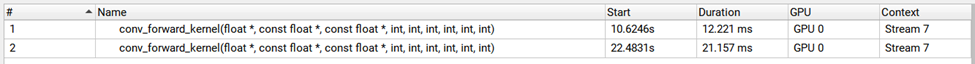
    
  - Version 2:

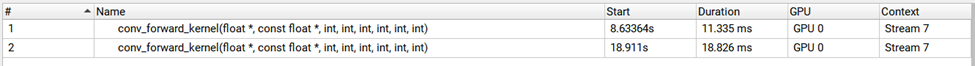
    
  - Ta thấy thời gian thực hiện kernel của version 2 đã nhanh hơn nhưng vì tổng thời gian chạy là rất nhanh nên việc thay đổi này là không đáng kể.

## **VERSION 3**
    - Cải tiến của version 1
    - Thực hiện tính toán và thử nghiệm để tìm ra TILE_WIDTH phù hợp
    - Với mỗi lớp tích chập xác định một TILE_WIDTH khác nhau
    - Đọc và chuyển dữ liệu vào shared memory để giảm thời gian truy xuất dữ liệu

In [19]:
!make version3
!make demo_GPU
print('--------------------------------------------')
!nsys profile ./demo_GPU

rm -f src/layer/custom/*.o demo demo_CPU demo_GPU
nvcc -arch=sm_75 --compile src/layer/custom/gpu_utils.cu -o src/layer/custom/gpu_utils.o -I./ -L/usr/local/cuda/lib64 -lcudart 
nvcc -arch=sm_75 --compile src/layer/custom/conv_forward_ver3.cu -o src/layer/custom/conv_forward_ver3.o -I./ -L/usr/local/cuda/lib64 -lcudart
nvcc -arch=sm_75 -o demo_GPU -lm -lcuda -lrt demo_GPU.o src/network.o src/mnist.o src/layer/*.o src/loss/*.o src/optimizer/*.o src/layer/custom/*.o -I./ -L/usr/local/cuda/lib64 -lcudart
--------------------------------------------
**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
mnist test number: 10000
Test using Lenet-5 on device:
Convolution c1 - GPU
GPU custom version 3:
	 - Layer Time: 156.75 ms
Convolution c3 - GPU
GPU custom version 3:
	 - Layer Time: 61.2328 ms
test acc: 0.8092


- Ta thấy thời gian chạy của version 3 là nhanh hơn version 1 nhưng vẫn không nhiều

- Version 1:
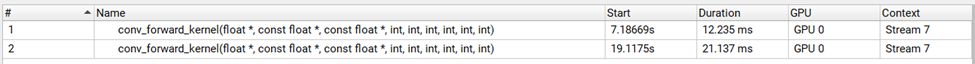
- Version 3:

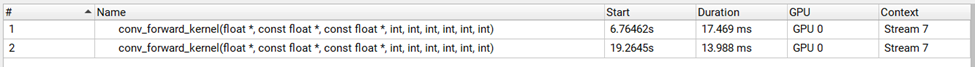


  - Ta thấy thời gian chạy kernel  của version 3 không nhanh hơn version 1 là bao nhiêu, thậm chí ở lớp chập c1 thời gian chạy của version 3 thậm chí còn lâu hơn. Điều này có thể là do việc di chuyển dữ liệu từ GMEM sang SMEM trong kernel cũng chiếm khá nhiều thời gian, làm cho thời gian cải thiện không đáng kể. Phần lớn thời gian cải thiện là nhờ việc áp dụng TILE_WIDTH  mới hợp lí hơn.

## **VERSION 4**
    - Kết hợp 3 version trên và đặt thêm một số cải tiến.
    - Đặt chỉ thị unroll trước các vòng lặp để trình biên dịch “unroll” vòng lặp, thay thế vòng lặp bằng một chuỗi các lệnh

In [20]:
!make version4
!make demo_GPU
print('--------------------------------------------')
!nsys profile ./demo_GPU

rm -f src/layer/custom/*.o demo demo_CPU demo_GPU
nvcc -arch=sm_75 --compile src/layer/custom/gpu_utils.cu -o src/layer/custom/gpu_utils.o -I./ -L/usr/local/cuda/lib64 -lcudart 
nvcc -arch=sm_75 --compile src/layer/custom/conv_forward_ver4.cu -o src/layer/custom/conv_forward_ver4.o -I./ -L/usr/local/cuda/lib64 -lcudart
nvcc -arch=sm_75 -o demo_GPU -lm -lcuda -lrt demo_GPU.o src/network.o src/mnist.o src/layer/*.o src/loss/*.o src/optimizer/*.o src/layer/custom/*.o -I./ -L/usr/local/cuda/lib64 -lcudart
--------------------------------------------
**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
mnist test number: 10000
Test using Lenet-5 on device:
Convolution c1 - GPU
GPU custom version 4:
	 - Layer Time: 129.756 ms
Convolution c3 - GPU
GPU custom version 4:
	 - Layer Time: 64.5905 ms
test acc: 0.8092


- Ta thấy sau các quá trình cải tiến thì thời gian chạy của version 4 là gần như tối ưu nhất.
- Nsight verison 4:

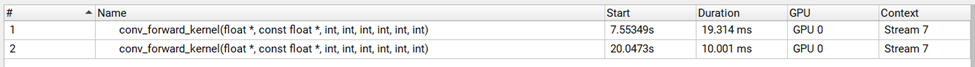


Ta thấy kết quả của version 4 chủ yếu được cải thiện ở hàm kernel của lớp chập c3. Còn thời gian chạy ở lớp chập c1 không khác đáng kể so với các version khác

##Tổng hợp kết quả của các version theo từng danh mục (ms)

|                  |     Lớp c1    |     Lớp c2    |     Kernel 1    |     Kernel 2    |     Memory    |
|------------------|---------------|---------------|-----------------|-----------------|---------------|
|     Version 0    |     35000     |     30000     |                 |                 |               |
|     Version 1    |     130       |     74        |     12          |     21          |     160       |
|     Version 2    |     122       |     66        |     11          |     18          |     150       |
|     Version 3    |     132       |     55        |     17          |     13          |     147       |
|     Version 4    |     134       |     50        |     19          |     10          |     146       |

- Thời gian chạy của GPU đã nhanh hơn rất nhiều so với CPU.
- Kết quả của việc cải thiện các version chủ yếu được thể hiện ở hàm kernel của lớp chập c2. Còn thời gian chạy ở lớp chập c1 các version đều cho ra kết quả khá giống nhau.
- Thậm chí ở version 4, thời gian chạy của lớp kernel 1 lớn hơn các version khác.
- Việc cải tiến không hiệu quả có thể là do các cải tiến làm tăng độ phức tạp tính toán.



# **Kết luận**
- Qua đồ án này chúng ra đã thấy được những lợi ích của việc triển khai các lớp tích chập trên GPU để tận dụng sức mạnh tính toán song song, từ đó tăng tốc độ tính toán và xử lí của máy tính
- Ngoài ra, chúng ta đã thử nghiệm một số tiến trình để tối ưu hoá phép tính song song trên GPU:
1.	Tiled shared memory convolution: Sử dụng tile để chia nhỏ dữ liệu đầu vào và thực hiện phép tích chập.
2.	Shared memory matrix multiplication: Đọc và chuyển dữ liệu vào shared memory để giảm thời gian truy xuất dữ liệu.
3.	Weight matrix (kernel values) in constant memory: Sử dụng bộ nhớ constant để lưu trữ ma trận trọng số
4.	Tuning with restrict and loop unrolling: Đặt chỉ thị unroll trước các vòng lặp để trình biên dịch “unroll” vòng lặp, thay thế vòng lặp bằng một chuỗi các lệnh.
5.	Sweeping various parameters to find best values (block sizes, amount of thread coarsening): Thực hiện tính toán và thử nghiệm để tìm ra TILE_WIDTH phù hợp.
6.	Multiple kernel implementations for different layer sizes: Với mỗi lớp tích chập xác định một tile_width khác nhau.


# **Thảo luận**
  Để làm đồ án này thì khá tốn thời gian cho việc tìm hiểu và làm quen với việc biên dịch và chạy code CUDA. Ngoài ra, việc tiếp cận với một dự án mã nguồn lớn như mạng CNN cũng rất tốn thời gian. Vì vậy, cần tốn một thời gian rất lâu để có thể xây dựng được phiên bản đầu tiên của lớp tích chập trên GPU.
  
  
  Sau khi tìm hiểu và làm quen được với việc triển khai dự án, thì nhóm em đã được đi vào sâu hơn kiến thức về cách một mạng CNN hoạt động. Biết được nhiều hơn về các cách tối ưu hoá các luống song song trong CUDA, đặt biệt là cách sử dụng bộ nhớ. Trong tương lai có thể tiếp tục thử cải tiến các phiên bản tiếp theo bằng cách sử dụng các stream khác nhau để overlap việc chuyển và tính toán dữ liệu.


# **Training**
    - Nếu muốn thực hiện lại quá trình training thì chạy cell ở dưới

In [21]:
!make demo
! ./demo

nvcc -arch=sm_75 --compile demo.cc -I./ -L/usr/local/cuda/lib64 -lcudart
nvcc -arch=sm_75 -o demo -lm -lcuda -lrt demo.o src/network.o src/mnist.o src/layer/*.o src/loss/*.o src/optimizer/*.o src/layer/custom/*.o -I./ -L/usr/local/cuda/lib64 -lcudart
---------- Menu ----------
1. Train
2. Test
3. Exit
Chọn một số: ^C
